# Before getting started

Make sure pixi is up to date by running the following command in your terminal:

```bash
pixi self-update
```

# Start JupyterLab

To get the Jupyter kernel to work, 

1. Run the following commands in the terminal in the ispy-readii directory:
    ```bash
    pixi shell --manifest-path=./pixi.toml

    pixi install

    python -m ipykernel install --user --name=ispy2-r2r --display-name "ispy2-r2r"

    ```
2. In the `Select Kernel` menu at the top right of the notebook, select `Jupyter Kernel` as the source. 

3. Refresh the options and one called `ispy-readii` should appear. Select this option.

# Imports

In [1]:
# General Imports
import os
import pandas as pd
import subprocess
import numpy as np
import matplotlib.pyplot as plt

# Path handling
from pathlib import Path

# Image Processing Libraries
import SimpleITK as sitk
from imgtools.io import read_dicom_series
from imgtools.autopipeline import AutoPipeline
from readii.loaders import loadSegmentation
from readii.image_processing import flattenImage
from readii.feature_extraction import singleRadiomicFeatureExtraction

ModuleNotFoundError: No module named 'pytz.tzinfo'

## Set  Dataset Name 

In [7]:
DATASET_NAME = "ISPY2"

# Set Path 


In [ ]:
# # MR paths
# MR_image_dir_path = Path(f"../../rawdata/{DATASET_NAME}/ISPY2-100899/10-26-2002-100899T0-ISPY2MRIT0-88595/51800.000000-ISPY2 VOLSER uni-lateral cropped original DCE-30523/")
# nifti_output_path = Path(f"../../procdata/{DATASET_NAME}/ISPY2-100899/converted_niftis_MR/ISPY2-100899_raw.nii.gz")
# bias_corr_path = Path(f"../../procdata/{DATASET_NAME}/ISPY2-100899/bias_corrected_MR/processed_image.nii.gz")

# # SEG path
# segmentation_file_path = Path(f"../../rawdata/{DATASET_NAME}/ISPY2-100899/10-26-2002-100899T0-ISPY2MRIT0-88595/51900.000000-ISPY2 VOLSER uni-lateral cropped Analysis Mask-78091/1-1.dcm")

In [8]:
# H4H processed data (using med-imagetools for SEG matching and resizing)

# MR paths
nifti_output_path = Path(f"../../procdata/{DATASET_NAME}/ISPY2_h4h_processed/ISPY2_001/MR_Series-11980/MR.nii.gz")
bias_corr_path = Path(f"../../procdata/{DATASET_NAME}/ISPY2_h4h_processed/ISPY2_001/MR_Series-11980/BiasCorrected_MR.nii.gz")

# SEG path
segmentation_file_path = Path(f"../../procdata/{DATASET_NAME}/ISPY2_h4h_processed/ISPY2_001/SEG_Series-74565/VOLSER_Analysis_Mask.nii.gz")

# ~~Run Med-Imagetools crawl~~

~~This creates a file used by READII to associate the images with the corresponding segmentation files.~~




In [130]:
# mit_input_dir = f"../../rawdata/{DATASET_NAME}"
# mit_output_dir = f"../../procdata/{DATASET_NAME}/mit_output"

# modalities = "MR,SEG"
# # LEAVE THIS ONE
# dry_run = False

# # Set up and run the pipeline
# pipeline = AutoPipeline(input_directory=mit_input_dir,
#                         output_directory=mit_output_dir,
#                         modalities=modalities,
#                         dry_run=dry_run,
#                         show_progress=False) 

# pipeline.run()


# Convert MRI to NIfTI  

In [ ]:
# Read all DICOM files as a 3D volume
# reader = sitk.ImageSeriesReader()
# dicom_series = reader.GetGDCMSeriesFileNames(str(MR_image_dir_path))
# reader.SetFileNames(dicom_series)
# mri_image = reader.Execute()

# # Save the raw MRI as NIfTI
# sitk.WriteImage(mri_image, str(nifti_output_path))
# print(f" DICOM converted to NIfTI: {nifti_output_path}")

DICOM converted to NIfTI: ..\..\procdata\ISPY2\ISPY2-100899\converted_niftis_MR\ISPY2-100899_raw.nii.gz


# Run Bias Correction

The `install_fsl.sh` lines 81-94 here. script installs `fsl-base` and `fslpy`, but there is an error with `fast`, which is used for bias correction. 
Therefore, an alternative approach is used instead of FSL. Here, `ANTs N4BiasFieldCorrection` is applied. 

Reference to Bias Correction:[N4 Bias Field Correction](https://simpleitk.org/doxygen/v2_3/html/classitk_1_1simple_1_1N4BiasFieldCorrectionImageFilter.html)  

In [ ]:
# Load the NIfTI image
print("Loading NIfTI file...")
input_image = sitk.ReadImage(str(nifti_output_path))

# Convert image to float32 (avoids intensity scaling issues)
input_image = sitk.Cast(input_image, sitk.sitkFloat32)

# Apply N4 Bias Field Correction
print("Applying N4 Bias Field Correction...")
corrector = sitk.N4BiasFieldCorrectionImageFilter()
output_image = corrector.Execute(input_image)

# Save the bias-corrected image as NIfTI
sitk.WriteImage(output_image, str(bias_corr_path))
print(f"Bias correction applied. Output saved at: {bias_corr_path}")

Loading NIfTI file...
Applying N4 Bias Field Correction...
Bias correction applied. Output saved at: ..\..\procdata\ISPY2\ISPY2_h4h_processed\ISPY2_002\MR_Series-62993\BiasCorrected_MR.nii.gz


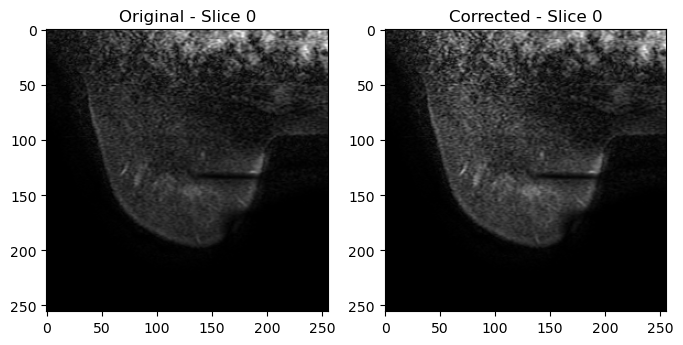

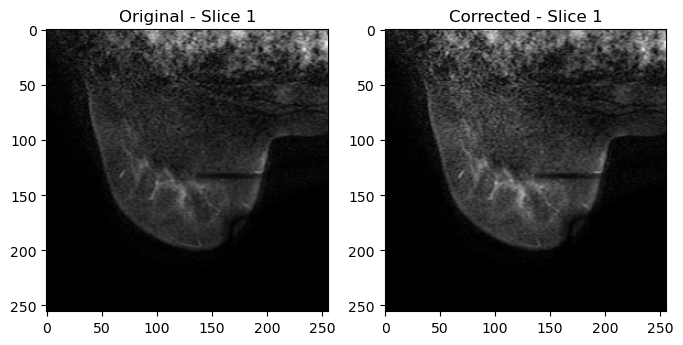

In [17]:
# Load NIfTI images
mr_image = sitk.ReadImage(nifti_output_path)
MR_corrected_image = sitk.ReadImage(bias_corr_path)

# Convert to NumPy arrays
original_array = sitk.GetArrayFromImage(mr_image)
bias_corrected_array = sitk.GetArrayFromImage(MR_corrected_image)

# Show first 2 slices (max is 640)
num_slices = min(2 , original_array.shape[0])

# Plot slices
for slice_idx in range(num_slices):
    fig, ax = plt.subplots(1, 2, figsize=(8, 5))
    
    ax[0].imshow(original_array[slice_idx], cmap="gray")
    ax[0].set_title(f"Original - Slice {slice_idx}")

    ax[1].imshow(bias_corrected_array[slice_idx], cmap="gray")
    ax[1].set_title(f"Corrected - Slice {slice_idx}")

    plt.show()

# Load in image and segmentation

In [18]:
# Load the segmentation file (for SEG format)

# # This returns a dictionary of segmentation images, with ROI names as keys and image objects as values
# seg_image_dict = loadSegmentation(segmentation_file_path, modality='SEG')

# # Get the segmentation image for the specific ROI of interest
# # Flatten the image if it has extra dimensions, making it 3D
# seg_image = flattenImage(seg_image_dict["VOLSER Analysis Mask"])

seg_image = sitk.ReadImage(str(segmentation_file_path))

print("SEG image size:", seg_image.GetSize())
print("MR bias correctied size:", MR_corrected_image.GetSize())

SEG image size: (256, 256, 504)
MR bias correctied size: (256, 256, 504)


# MRI Cropping & Segmentation Binarization  

- **Reference**: [ISPY2 TCIA Collection](https://www.cancerimagingarchive.net/collection/ispy2/)  
- **Doc**: *Analysis-mask-files-description.v20211020.doc* (FTV mask details)  
- **Studies**: *I-SPY 1 (Breast-MRI-NACT-Pilot)* and *I-SPY 2 (ACRIN_6657 / ACRIN_6698)*  

The FTV segmentation on DCE-MRI involves:  
1. Manual VOI selection  
2. Background masking  
3. PE (Percent Enhancement) thresholding  
4. Connectivity filtering  
5. Manual exclusion of non-tumor regions  

> **Note**: These are **inverse masks** — voxel value `0` indicates **tumor** (FTV-included).

Our current segmentation contains values: `[0.0, 0.004, 0.008, 0.067, 0.125, 0.129, 0.133, 0.192]`.  
To comply with **PyRadiomics** (which expects binary masks):  
- Convert voxels with `0` → `1` (tumor)  
- All others (≥1) → `0` (background)  


Original SEG values: [0.    0.004 0.008 0.067 0.125 0.129 0.133 0.192]
Binary mask values: [0 1]
Slices containing tumor: [23, 24, 25, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]


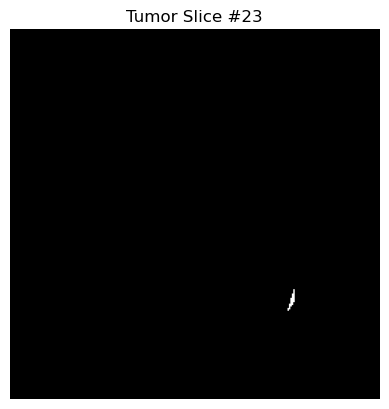

In [ ]:
# 1. SEG binarization and removal of empty slices

# Convert SEG image to array
seg_array = sitk.GetArrayFromImage(seg_image)

# Make a copy to preserve the original segmentation
seg_array_copy = seg_array.copy()

# Remove slices with no tumor (i.e., slices where all voxel values are 0)
non_empty_slices = np.any(seg_array_copy != 0, axis=(1, 2))

# Keep only tumor-containing slices in SEG and MR arrays
mask_array = seg_array_copy[non_empty_slices]
mr_cropped_array = bias_corrected_array[non_empty_slices]

# Binarize the mask:
# Voxels originally 0 → 1 (tumor)
# Voxels originally ≥1 → 0 (background)
binary_mask_array = np.where(mask_array == 0, 1, 0)

print("Original SEG values:", np.round(np.unique(seg_array), 3))
print("Binary mask values:", np.unique(binary_mask_array))

# Convert binary mask array back to a SimpleITK image
binary_mask_image = sitk.GetImageFromArray(binary_mask_array)

# Copy spatial metadata from the original SEG image and save
binary_mask_image.SetSpacing(seg_image.GetSpacing())
binary_mask_image.SetOrigin(seg_image.GetOrigin())
binary_mask_image.SetDirection(seg_image.GetDirection())
sitk.WriteImage(binary_mask_image, f"../../procdata/{DATASET_NAME}/ISPY2_h4h_processed/ISPY2_001/SEG_Series-74565/Binary_Mask.nii.gz")

# save cropped MR image 
mr_cropped_image = sitk.GetImageFromArray(mr_cropped_array)
mr_cropped_image.SetSpacing(mr_image.GetSpacing())
mr_cropped_image.SetOrigin(mr_image.GetOrigin())
mr_cropped_image.SetDirection(mr_image.GetDirection())
sitk.WriteImage(mr_cropped_image, f"../../procdata/{DATASET_NAME}/ISPY2_h4h_processed/ISPY2_001/SEG_Series-74565/Cropped_BiasCorrected.nii.gz")

# Find slices containing tumor 
tumor_slices = [i for i in range(binary_mask_array.shape[0]) if np.any(binary_mask_array[i] == 1)]
print("Slices containing tumor:", tumor_slices)

# Visualize the first tumor-containing slice, if any
if tumor_slices:
    plt.imshow(binary_mask_array[tumor_slices[0]], cmap='gray')
    plt.axis('off')
    plt.title(f"Tumor Slice #{tumor_slices[0]}")
    plt.show()
else:
    print("No tumor-containing slices found.")


In [ ]:
print("MR cropped (bias-corrected) shape:", mr_cropped_array.shape)
print("Binary mask shape:", binary_mask_array.shape)


MR cropped (bias-corrected) shape: (72, 256, 256)
Binary mask shape: (72, 256, 256)


## Extract Radiomic Features

In [22]:
# Pick which config settings to use for PyRadiomics feature extraction
pyradiomics_param_file_path = "../config/default_pyradiomics.yaml"

# Run PyRadiomics feature extraction with REAII function
radiomic_features_dict = singleRadiomicFeatureExtraction(
    mr_cropped_image,
    binary_mask_image,
    pyradiomics_param_file_path,
    randomSeed=10
)

# Convert the flat dictionary into a single-row DataFrame
radiomic_df = pd.DataFrame([radiomic_features_dict])

# Optional: Print preview
print("Radiomic Features (Sample-100999):")
print(pd.DataFrame([radiomic_features_dict]).T) 

Radiomic Features (Sample-100999):
                                                                                                 0
diagnostics_Versions_PyRadiomics                                                            v3.1.4
diagnostics_Versions_Numpy                                                                  1.26.4
diagnostics_Versions_SimpleITK                                                               2.4.0
diagnostics_Versions_PyWavelet                                                               1.8.0
diagnostics_Versions_Python                                                                3.10.16
diagnostics_Configuration_Settings               {'minimumROIDimensions': 2, 'minimumROISize': ...
diagnostics_Configuration_EnabledImageTypes                                       {'Original': {}}
diagnostics_Image-original_Hash                           99c585e8d9da9932129737787630f42e9fa8239b
diagnostics_Image-original_Dimensionality                                 

# Save out the results of the feature extraction

In [23]:
# Save to CSV
save_radiomics_path = Path("../../results/ISPY2/h4h_readii_radiomic_features.csv")
save_radiomics_path.parent.mkdir(parents=True, exist_ok=True)
radiomic_df.to_csv(save_radiomics_path, index=False)